# Solution to the preparatory lab 
In this notebook, we use the following modules `numpy` and `maze`. The latter is a home made module, where all the solutions to the questions are implemented. We will refer to it at each answer, and we encourage you to read it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import maze as mz
import mazeSolver as ms
%load_ext autoreload
%autoreload 2

# Problem 1: Shortest path in the maze

The objective of problem 1 is to solve the shortest path problem in a maze. We start first by describing the maze as a numpy array. 

In [2]:
# Description of the maze as a numpy array
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0],
])
# with the convention 
# 0 = empty cell
# 1 = obstacle
# 2 = exit of the Maze

The method `maze.draw_maze()` helps us draw the maze given its numpy array discription.  

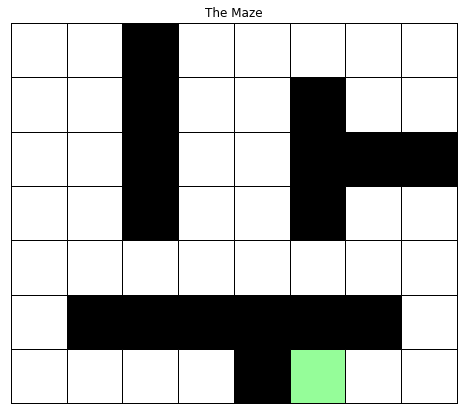

In [3]:
mz.draw_maze(maze)

## MDP formulation

We propose the following MDP formulation: 

#### State space $\mathcal{S}$
We model the state space as the set of all possible positions of the player in the maze. Note that we exclude the obstacles' position since these are impossible states to be in for the player. Formally, the state space is

$$\mathcal{S} = \big\lbrace (i,j):\textrm{such that the cell
} (i,j) \textrm{ is not an obstacle}\big\rbrace.$$
> **Note:** The choice of state space is not unique. For instance one could consider $\mathcal{S}$ to be the set of all positions in the  maze regardless of whether they correspond to an obstacle or not. But note that, this will increase the size $\vert \mathcal{S} \vert $. This is fine for small mazes, but it leads to many redundant states as the maze dimension increases.

#### Action space $\mathcal{A}$
We allow the player to chose to either move `left`, `right`, `down`, `up` or not move at all (`stay`). Note that sometimes the player cannot move in a certain direction because of an obstacle or a wall, yet we permit this to be action. We will see that this is not an issue as long as we define our transition probabilities and rewards appropriately.
Formally, the action space is

$$\mathcal{A} = \lbrace \textrm{up}, \textrm{ down}, \textrm{ left}, \textrm{ right}, \textrm{ stay} \rbrace.$$
> **Note:** Once again, the choice of the action space is not unique. For instance one could remove the action `stay` from $\mathcal{A}$, but then one should modify the transition probabilities accordingly as well as the rewards.  


#### Transition probabilities $\mathcal{P}$
Note that there is no randomness involved upon taking an action by the player. As a consequence, the transition probabilities are deterministic. More precisely,   
- If at state (or position) $s$ taking action (or move) $a$ does not lead to a wall or an obstacle but to another state (or position) $s'$, then $\mathbb{P}(s' \vert s, a) = 1$. 
- If at state (or position)  $s$ taking action (or move) $a$ leads to a wall or an obstacle, the player remains in his state (or position) $s$, then $\mathbb{P}(s \vert s, a) = 1$.

> **Note**: Recall that for a fixed $s \in \mathcal{S}$ and $a \in \mathcal{A}$ we have $\sum_{s' \in \mathcal{S}} \mathbb{P}(s' \vert s, a) = 1$, thus if for some $s' \in \mathcal{S}$  we have $\mathbb{P}(s' \vert s, a) = 1$, then for all $s'' \in \mathcal{S} \backslash \lbrace s'\rbrace$ we have $\mathbb{P}(s'' \vert s, a) = 0$,

#### Rewards $\mathcal{R}$
The objective of the player is to find the exit of the maze while avoiding the obstacles.    
   - If at state $s$, taking action $a$, leads to a wall or an obstacle then $r(s,a) = -\infty$
   - If at state $s$, taking action $a$, leads to some other position in the maze that is not the exit nor a wall nor an obstacle, then $r(s, a) = -1$. 
   - If at state $s$, taking action $a$, leads to the exit then $r(s ,a) = 0$. 
> **Note**: Here the rewards are independent of time (i.e. $r_t(.,.) = r(.,.)$). 


### Implementation
The above MDP formulation is implemented as a class ``maze.Maze`` in the file [maze.py](./maze.py) which given a matrix description of the maze instanciates the state space, action space, transition probabilities and rewards. 

> **Note:** In the class `maze.Maze` each state $s = (i,j)$ is given a unique identifier $s_{id} \in \lbrace 0, , \dots, \vert S \vert -1 \rbrace$. In other words, the state space from an implementation perspective is viewed as the set of integers $\lbrace 0, , \dots, \vert S \vert -1 \rbrace$. This mapping is done via the dictionary `self.map` and its inverse mapping via the dictionary `self.states`.   

In [4]:
# Create an environment maze
enemyPos = (6,7)
env = mz.Maze(maze, enemy=enemyPos, e_can_stay=True)
# env.show()

##  Dynamic Programming 

Before solving the MDP problem, recall that the finite horizon objective function is 
$$
    \mathbb{E} \Big[ \sum_{t=0}^T r(s_t, a_t) \Big],
$$
where $T$ is the horizon.
Recall the Bellman equation 
\begin{equation}
\forall s \in \mathcal{S} \qquad  V(s) = \max_{a \in \mathcal{A}} \Big\lbrace r(s,a) + \sum_{s' \in \mathcal{S}} \mathbb{P}(s'\vert s,a) V(s') \Big\rbrace
\end{equation}
The dynamic programming solution for the finite horizon MDP problem consists of solving the above backward recursion. The method `maze.dynamic_programming` achieves this. 
> **Note:** To find the optimal path, it is enough to set the time horizon $T = 10$. Indeed, looking at the maze one can see that the player needs at least 10 steps to attain the exit $B$, if her starting position is at $A$. In fact if you set the time horizon less than 10, you will see that you do not find the optimal path.



In [8]:
# Finite horizon
horizon = 20
# Solve the MDP problem with dynamic programming 
V, policy= ms.dynamic_programming(env,horizon)

In [9]:
# Simulate the shortest path starting from position A
method = 'DynProg'
start  = (0,0)
path, path_enemy = env.simulate(start, policy, method)

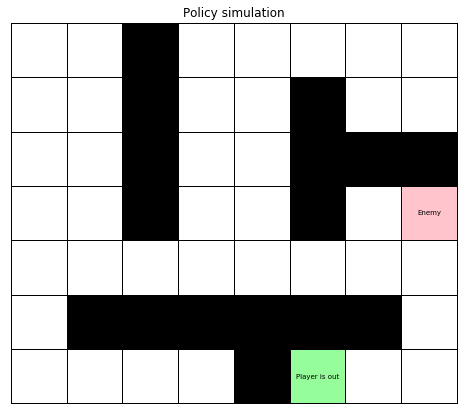

In [11]:
# Show the shortest path 
mz.animate_solution(maze, path, path_enemy)

# Simulation for time horizon

In [ ]:
enemyPos = (6,7)
start  = (0,0)
exit = (6,7)
env = mz.Maze(maze, enemy=enemyPos)

# Discount Factor 
gamma   = 0.95; 
# Accuracy treshold 
epsilon = 0.0001;

T = 30
n_interaction = 3
dp_h2n_win = defaultdict(int)
vi_h2n_win = defaultdict(int)

for horizon in range(T):
    V_dp, policy_dp= ms.dynamic_programming(env,horizon);
    V_vi, policy_vi = ms.value_iteration(env, gamma, epsilon)
    for n in range(n_interaction):
        path, path_enemy = env.simulate(start, policy_dp, 'DynProg');
        dp_h2n_win[horizon] += (path[-1] == exit)
        path, path_enemy = env.simulate(start, policy_vi, 'ValIter');
        vi_h2n_win[horizon] += (path[-1] == exit)

In [ ]:
time = [i for i in range(T)]
avg_n_win_dp = [w/n_interaction for h,w in dp_h2n_win.items()]
avg_n_win_vi = [w/n_interaction for h,w in vi_h2n_win.items()]

In [ ]:
plt.plot(time, avg_n_win_dp, 'ro', label="Dynamic Programig")
plt.plot(time, avg_n_win_vi, 'go', label="Value Iteration")
plt.xlabel('Horizon T')
plt.ylabel('Estimated probability')
plt.title('Illustrate an optimal policy', fontweight="bold")
plt.legend(bbox_to_anchor=(0.05, .95), loc='upper left', borderaxespad=0.)

# plt.savefig('time_eval.png')

## Value Iteration

Here we solve the discounted infinite-horizon MDP problem using value iteration, the objective here is to find a stationary policy $\pi$ that minimizes the infinite horizon objective with a discount factor $\gamma$ 
$$
    \mathbb{E} \Big[\sum_{t=0}^\infty \gamma^t r\big(s_t, \pi(s_t)\big) \Big].
$$
Recall the Bellman equation in the case of a stationary policy $\pi$ 
\begin{equation}
\forall s \in \mathcal{S} \qquad  V^*(s) = \max_{\pi} \Big\lbrace r(s,\pi(s)) + \gamma \sum_{s' \in \mathcal{S}} \mathbb{P}(s'\vert s,\pi(s)) V^*(s') \Big\rbrace
\end{equation}
or equivalently in terms of the Bellman operator $\mathcal{L}$ 
\begin{equation}
V^* =  \mathcal{L}(V^*)
\end{equation}
where 
\begin{equation}
   \forall s \in \mathcal{S} \qquad  \mathcal{L}(V)(s) = \max_{\pi} \Big\lbrace r(s,\pi(s)) + \gamma \sum_{s' \in \mathcal{S}} \mathbb{P}(s'\vert s,\pi(s)) V(s') \Big\rbrace. 
\end{equation}
Value iteration solves the Bellman equation described above. This method is implemented as `maze.value_iteration` in the file [maze.py]().

> **Note:** Recall that the mapping $\mathcal{L}$ is a contraction, therefore value iteration converges. To achieve an $\varepsilon>0$ approximation (i.e. $\Vert V^* - V_{n+1} \Vert \le \varepsilon$),
 the stopping criterion of value iteration is $\Vert V - \mathcal{L}(V) \Vert < \frac{1-\gamma}{\gamma}\varepsilon$.

In [ ]:
# Discount Factor 
gamma   = 0.95; 
# Accuracy treshold 
epsilon = 0.0001;
V, policy = mz.value_iteration(env, gamma, epsilon)

In [ ]:
method = 'ValIter';
start  = (0,0);
path = env.simulate(start, policy, method)

In [ ]:
# Show the shortest path 
mz.animate_solution(maze, path)

## Random rewards 

### The new MDP formulation 
As stated in the problem statement, we only modify the rewards $\mathcal{R}$ to be random. In fact we will only need to modify the rewards corresponding to the state action pair $(s,a)$ that lead to either the cell R1 or R2.
#### Rewards $\mathcal{R}$
The objective of the player is to find the exit of the maze while avoiding the obstacles.    
   - If at state $s$, taking action $a$, leads to the cell R1 then the reward is random according to the following     $$ R(s,a) = \begin{cases}
            -7 \quad \textrm{ w.p. } 0.5 \\
            -1 \quad \textrm{ w.p. } 0.5
            \end{cases} 
     $$
   - If at state $s$, taking action $a$, leads to the cell R2 then the reward is random according to the following 
     $$ R(s,a) = \begin{cases}
            -2 \quad \textrm{ w.p. } 0.5 \\
            -1 \quad \textrm{ w.p. } 0.5
            \end{cases} 
     $$
   - The remaining rewards remain deterministic and with the same values as in the previous formulation.

> **Note**: The fact that you stay in a cell for a number of rounds $n$ means that you are forced to incur the reward of ending up in that state for an additional $n$ times. Thus, instead of modifying the transition probabilities, we can modify the reward of ending up at that round by multiplying it by $n + 1$.  

### Solving the new MDP 
As mentioned in the appendix [random_rewards.pdf]() (see in canvas), when solving the problem we will only have to look at the average rewards instead of the realization of the rewards, and the methods implemented for the previous case remain unchanged.  

> **Note**: In the implementation, the only change will be the rewards. In addition, the policies we obtain remain deterministic. However, when running a policy the accumulated reward is random, but its average over multiple repetitions should converge to the value function. 

In [ ]:
# Description of the maze as a numpy array
maze = np.array([
    [ 0, 0, 1, 0, 0, 0,  0],
    [ 0, 0, 1, 0, 0, 0,  0],
    [ 0, 0, 1, 0, 0, 0,  0],
    [ 0, 0, 0, 0, 0, 0, -1],
    [ 0, 1, 1, 1, 1, 1,  0],
    [-6, 0, 0, 0, 0, 2,  0]
])
# with the convention 
#  0 = empty cell
#  1 = obstacle
#  2 = exit of the Maze
# -n = trapped cell with probability 0.5. If the cell is trapped the player must stay there for n times.  

In [ ]:
mz.draw_maze(maze);

### Dynamic programming 

Run the following python code to obtain the optimal solution of the newly formulated MDP with dynamic programming. 

In [ ]:
# Create an environment maze
env = mz.Maze(maze, random_rewards=True)
# env.show()

In [ ]:
# Finite horizon
horizon = 15
# Solve the MDP problem with dynamic programming 
V, policy= mz.dynamic_programming(env,horizon);
# Simulate the shortest path starting from position A
method = 'DynProg';
start  = (0,0);
path = env.simulate(start, policy, method);
# Show the shortest path 
mz.animate_solution(maze, path)

> **Note:** The animation does not illustrate the event where the player is trapped as it assumes average rewards. Nonetheless, the shown policy is the optimal one.     

### Value iteration  

Run the following python code to obtain the optimal solution of the newly formulated MDP with value iteration.

In [ ]:
# Discount Factor 
gamma   = 0.95; 
# Accuracy treshold 
epsilon = 0.0001;
V, policy = mz.value_iteration(env, gamma, epsilon)

method = 'ValIter';
start  = (0,0);
path = env.simulate(start, policy, method)
# Show the shortest path 
mz.animate_solution(maze, path)